In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

In [2]:
# -----------------------------
# Surface-17 (d=3 rotated) teaching layout
# data qubits: d0..d8 (3x3)
# Z ancilla:  az0..az3 (4 plaquettes, weight-4)
# X ancilla:  ax0..ax3 (4 boundary checks, weight-2)  —— 采用你图1的边界风格
# -----------------------------

# Data coordinates (for plotting)
DATA_COORDS = {
    "d0": (0,2), "d1": (1,2), "d2": (2,2),
    "d3": (0,1), "d4": (1,1), "d5": (2,1),
    "d6": (0,0), "d7": (1,0), "d8": (2,0),
}

# Z plaquettes (与你之前一致)
Z_CHECKS = [
    {"name":"Zp0", "anc":"az0", "data":["d0","d1","d3","d4"]},
    {"name":"Zp1", "anc":"az1", "data":["d1","d2","d4","d5"]},
    {"name":"Zp2", "anc":"az2", "data":["d3","d4","d6","d7"]},
    {"name":"Zp3", "anc":"az3", "data":["d4","d5","d7","d8"]},
]

# X boundary checks (按你图1的“外侧”位置关系)
X_CHECKS = [
    {"name":"Xs0", "anc":"ax0", "data":["d0","d1"]},  # top (above d0,d1)
    {"name":"Xs1", "anc":"ax1", "data":["d2","d5"]},  # right (right of d2,d5)
    {"name":"Xs2", "anc":"ax2", "data":["d3","d6"]},  # left  (left of d3,d6)
    {"name":"Xs3", "anc":"ax3", "data":["d7","d8"]},  # bottom (below d7,d8)
]


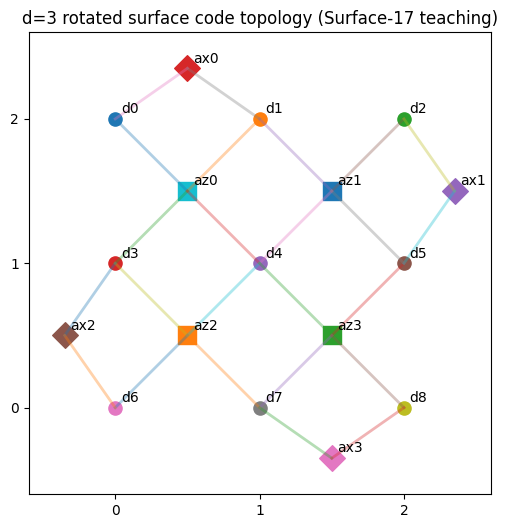

In [3]:
def plot_surface17_topology():
    fig, ax = plt.subplots(figsize=(6,6))

    # draw data nodes
    for dq, (x,y) in DATA_COORDS.items():
        ax.scatter([x],[y], s=90)
        ax.text(x+0.04, y+0.04, dq, fontsize=10)

    # helper center of list
    def center_of(dlist):
        xs = [DATA_COORDS[d][0] for d in dlist]
        ys = [DATA_COORDS[d][1] for d in dlist]
        return float(np.mean(xs)), float(np.mean(ys))

    # place Z ancilla at plaquette centers (squares)
    for i, stab in enumerate(Z_CHECKS):
        cx, cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker='s', s=170)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        # connect
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # place X ancilla (diamonds) at your desired outer positions
    # ax0 above d0,d1
    ax0x, ax0y = (DATA_COORDS["d0"][0]+DATA_COORDS["d1"][0])/2, DATA_COORDS["d0"][1]+0.35
    # ax1 right of d2,d5
    ax1x, ax1y = DATA_COORDS["d2"][0]+0.35, (DATA_COORDS["d2"][1]+DATA_COORDS["d5"][1])/2
    # ax2 left of d3,d6
    ax2x, ax2y = DATA_COORDS["d3"][0]-0.35, (DATA_COORDS["d3"][1]+DATA_COORDS["d6"][1])/2
    # ax3 below d7,d8
    ax3x, ax3y = (DATA_COORDS["d7"][0]+DATA_COORDS["d8"][0])/2, DATA_COORDS["d7"][1]-0.35

    AX_POS = {"ax0":(ax0x,ax0y), "ax1":(ax1x,ax1y), "ax2":(ax2x,ax2y), "ax3":(ax3x,ax3y)}

    for stab in X_CHECKS:
        cx, cy = AX_POS[stab["anc"]]
        ax.scatter([cx],[cy], marker='D', s=170)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1,2])
    ax.set_title("d=3 rotated surface code topology (Surface-17 teaching)")
    plt.show()

plot_surface17_topology()


In [4]:
def make_named_qubits():
    qregs = {}
    # data
    for i in range(9):
        qregs[f"d{i}"] = QuantumRegister(1, f"d{i}")
    # ancilla Z
    for i in range(4):
        qregs[f"az{i}"] = QuantumRegister(1, f"az{i}")
    # ancilla X
    for i in range(4):
        qregs[f"ax{i}"] = QuantumRegister(1, f"ax{i}")
    return qregs

def make_named_syndrome_bits():
    cregs = {}
    for i in range(4):
        cregs[f"sZ{i}"] = ClassicalRegister(1, f"sZ{i}")
    for i in range(4):
        cregs[f"sX{i}"] = ClassicalRegister(1, f"sX{i}")
    return cregs

def Q(qregs, name):
    return qregs[name][0]

def C(cregs, name):
    return cregs[name][0]

def measure_one_x_check(qc, qregs, ax_name, data_names, cbit):
    """X-check: H(ax), CNOT(ax->data)*, H(ax), measure(ax)->cbit"""
    axq = Q(qregs, ax_name)
    qc.h(axq)
    for d in data_names:
        qc.cx(axq, Q(qregs, d))
    qc.h(axq)
    qc.measure(axq, cbit)


In [6]:
def measure_one_z_check(qc, qregs, az_name, data_names, cbit):
    """Z-check: CNOT(data->az)*, measure(az)->cbit"""
    azq = Q(qregs, az_name)
    for d in data_names:
        qc.cx(Q(qregs, d), azq)
    qc.measure(azq, cbit)


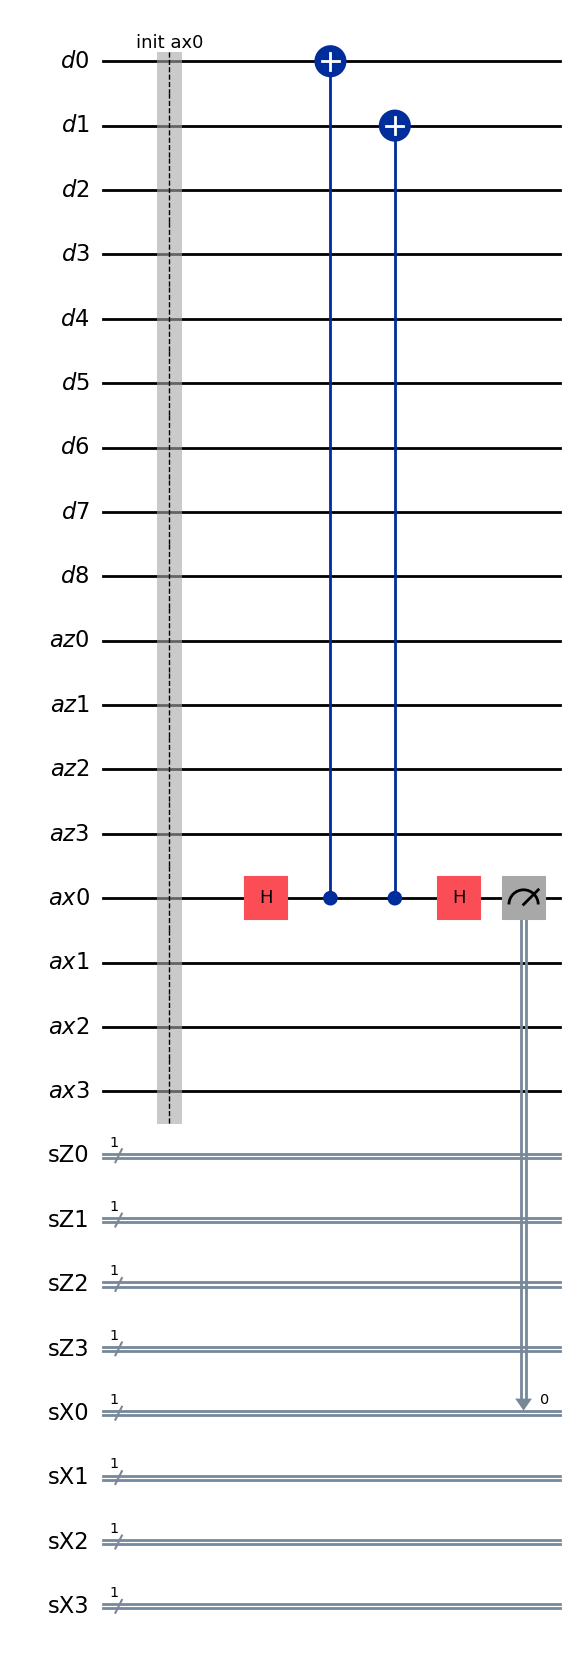

In [5]:
# 展示一个 X 稳定子（例如 ax0: d0,d1）的电路
qregs = make_named_qubits()
cregs = make_named_syndrome_bits()
qc_x1 = QuantumCircuit(*qregs.values(), *cregs.values(), name="X_check_ax0")

# reset ancilla to |0>（Qiskit 默认初态就是 |0>，这里用 barrier 强调步骤）
qc_x1.barrier(label="init ax0")
measure_one_x_check(qc_x1, qregs, "ax0", ["d0","d1"], C(cregs,"sX0"))

display(qc_x1.draw("mpl", fold=-1))


In [7]:
def build_one_round():
    """One full round: all Z checks then all X checks (with barriers for teaching clarity)."""
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="One_round_surface17")

    # ----- Z checks -----
    qc.barrier(label="Z-checks begin")
    for i, stab in enumerate(Z_CHECKS):
        measure_one_z_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sZ{i}"))
        qc.barrier(label=f"after {stab['anc']}")

    # ----- X checks -----
    qc.barrier(label="X-checks begin")
    for i, stab in enumerate(X_CHECKS):
        measure_one_x_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sX{i}"))
        qc.barrier(label=f"after {stab['anc']}")

    return qc


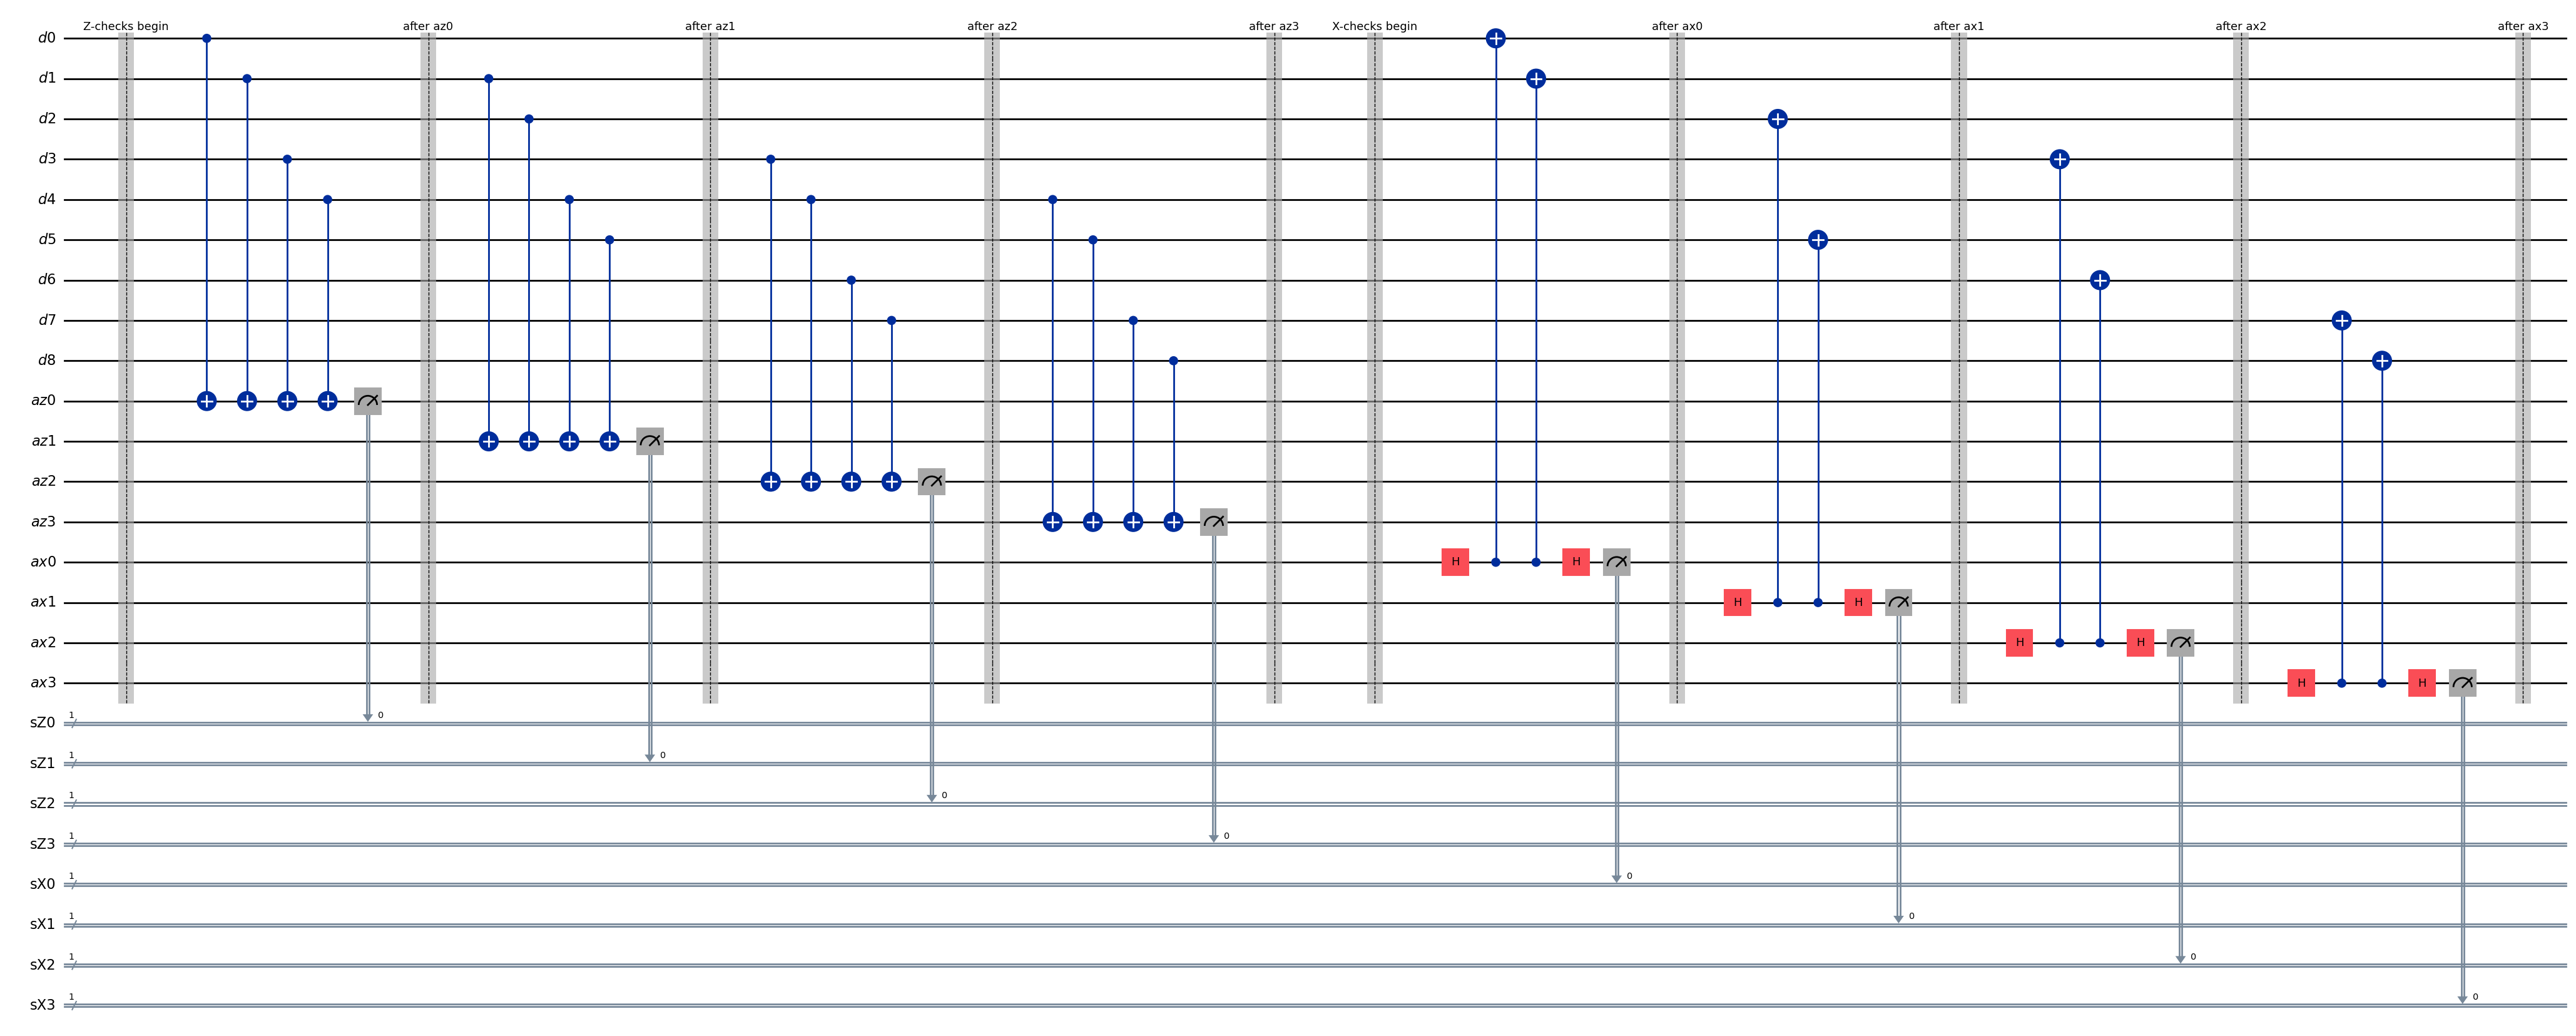

In [8]:
qc_round = build_one_round()
display(qc_round.draw("mpl", fold=-1))


In [9]:
backend = AerSimulator()

def run_counts(qc, shots=1):
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    return res.get_counts()

def parse_syndrome_from_key(key, reverse=False):
    clean = re.sub(r'[^01]', '', key)
    # 我们只关心 8 个 syndrome bits（4个sZ + 4个sX）
    sel = clean[-8:]
    if reverse:
        sel = sel[::-1]
    bits = [int(b) for b in sel]
    sZ = bits[0:4]
    sX = bits[4:8]
    return sZ, sX, sel, clean


In [10]:
def build_single_X_candidates():
    """
    For each data qubit di, compute which Z checks contain it:
    pattern = (sZ0..sZ3) where bit=1 if di in Zp_k
    Return pattern -> list of candidates
    """
    cand = {}
    for i in range(9):
        d = f"d{i}"
        pattern = tuple(1 if d in stab["data"] else 0 for stab in Z_CHECKS)
        cand.setdefault(pattern, []).append(d)
    return cand

X_CAND = build_single_X_candidates()

def toy_decode_single_X(sZ):
    pattern = tuple(sZ)
    cands = X_CAND.get(pattern, [])
    if len(cands) == 0:
        return None, []
    # 教学版：选一个代表（最小编号），同时返回全部候选方便解释
    return sorted(cands)[0], sorted(cands)


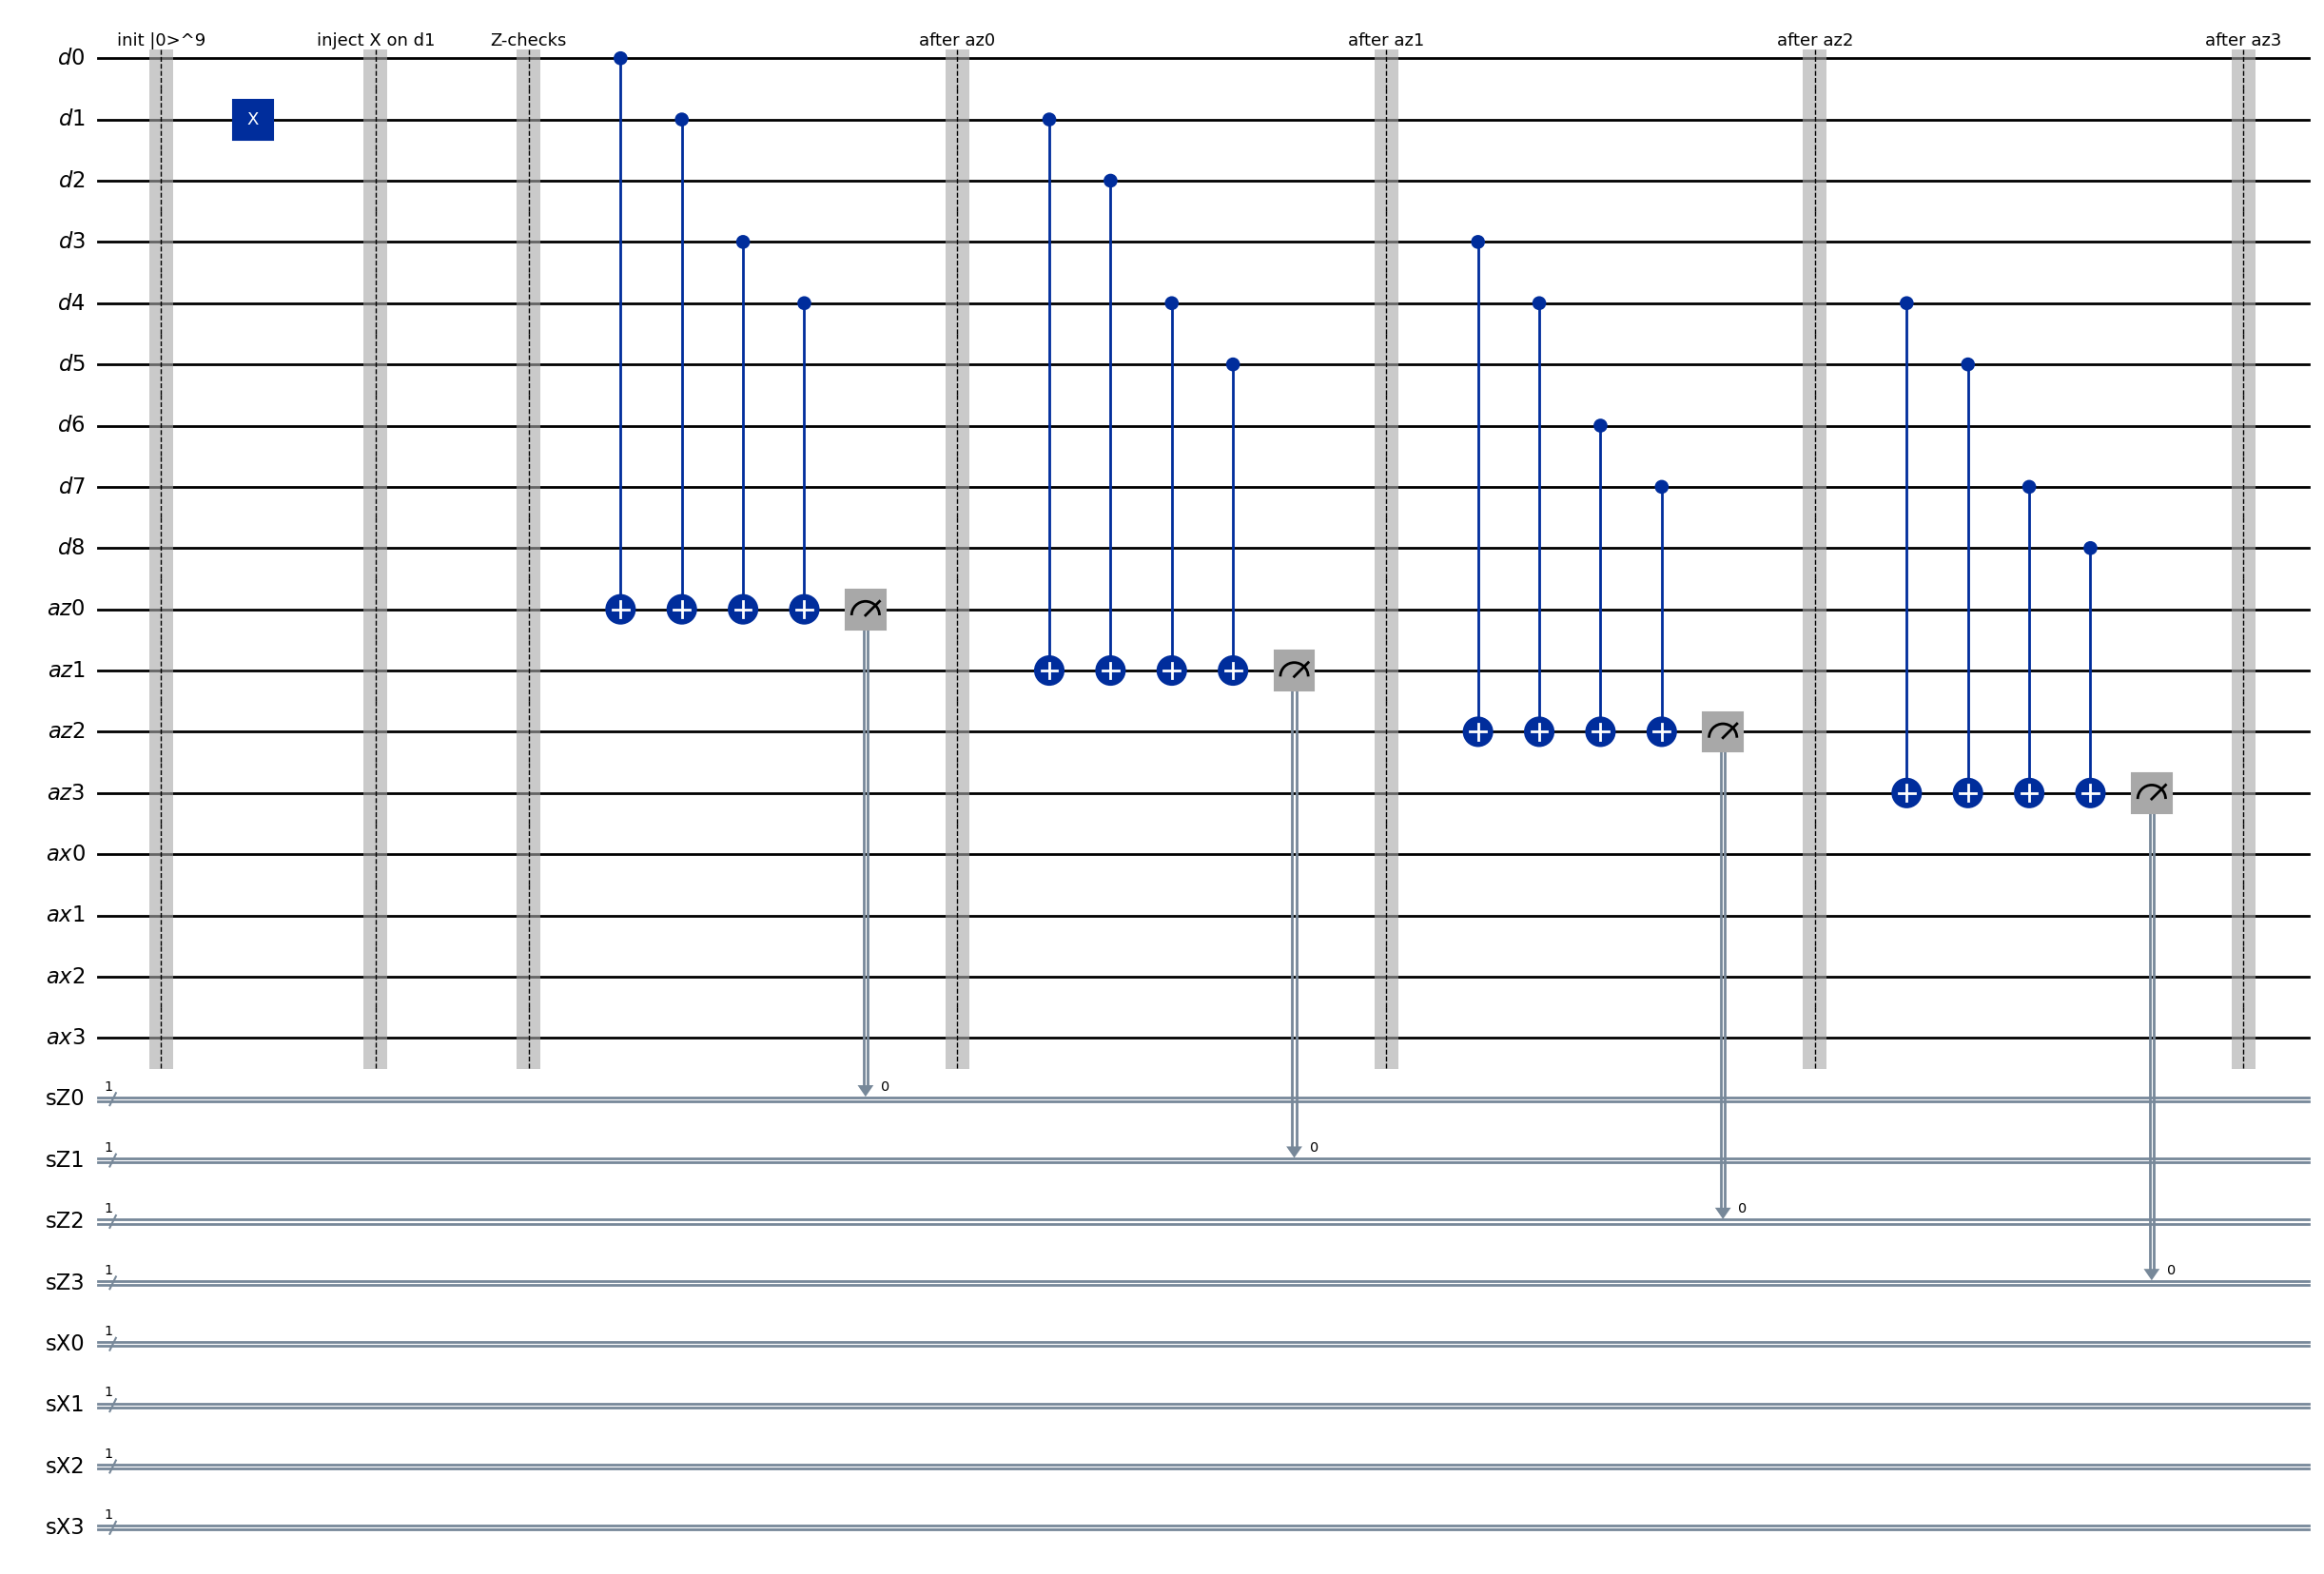

counts: {'0 0 0 0 0 0 1 1': 1}
raw key: 0 0 0 0 0 0 1 1
selected 8 bits: 00000011  (sZ0..sZ3 | sX0..sX3)
sZ: [0, 0, 0, 0]    (Z-check syndrome; X errors flip these)


In [11]:
def circuit_inject_X_then_measure_Z_only(err_data="d1"):
    """
    为了“输出可解释”，这里只测 Z-checks（X-checks 会在 |0>^n 上随机，容易干扰理解）。
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="InjectX_then_Zchecks")

    # data init: |0>^n (默认)
    qc.barrier(label="init |0>^9")

    # inject X error
    qc.x(Q(qregs, err_data))
    qc.barrier(label=f"inject X on {err_data}")

    # measure Z checks only
    qc.barrier(label="Z-checks")
    for i, stab in enumerate(Z_CHECKS):
        measure_one_z_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sZ{i}"))
        qc.barrier(label=f"after {stab['anc']}")

    return qc

qc_xerr = circuit_inject_X_then_measure_Z_only("d1")
display(qc_xerr.draw("mpl", fold=-1))

counts = run_counts(qc_xerr, shots=1)
key = list(counts.keys())[0]
sZ, sX, sel, clean = parse_syndrome_from_key(key, reverse=False)

print("counts:", counts)
print("raw key:", key)
print("selected 8 bits:", sel, " (sZ0..sZ3 | sX0..sX3)")
print("sZ:", sZ, "   (Z-check syndrome; X errors flip these)")


Toy decoder candidates: []
Toy decoder choose: None


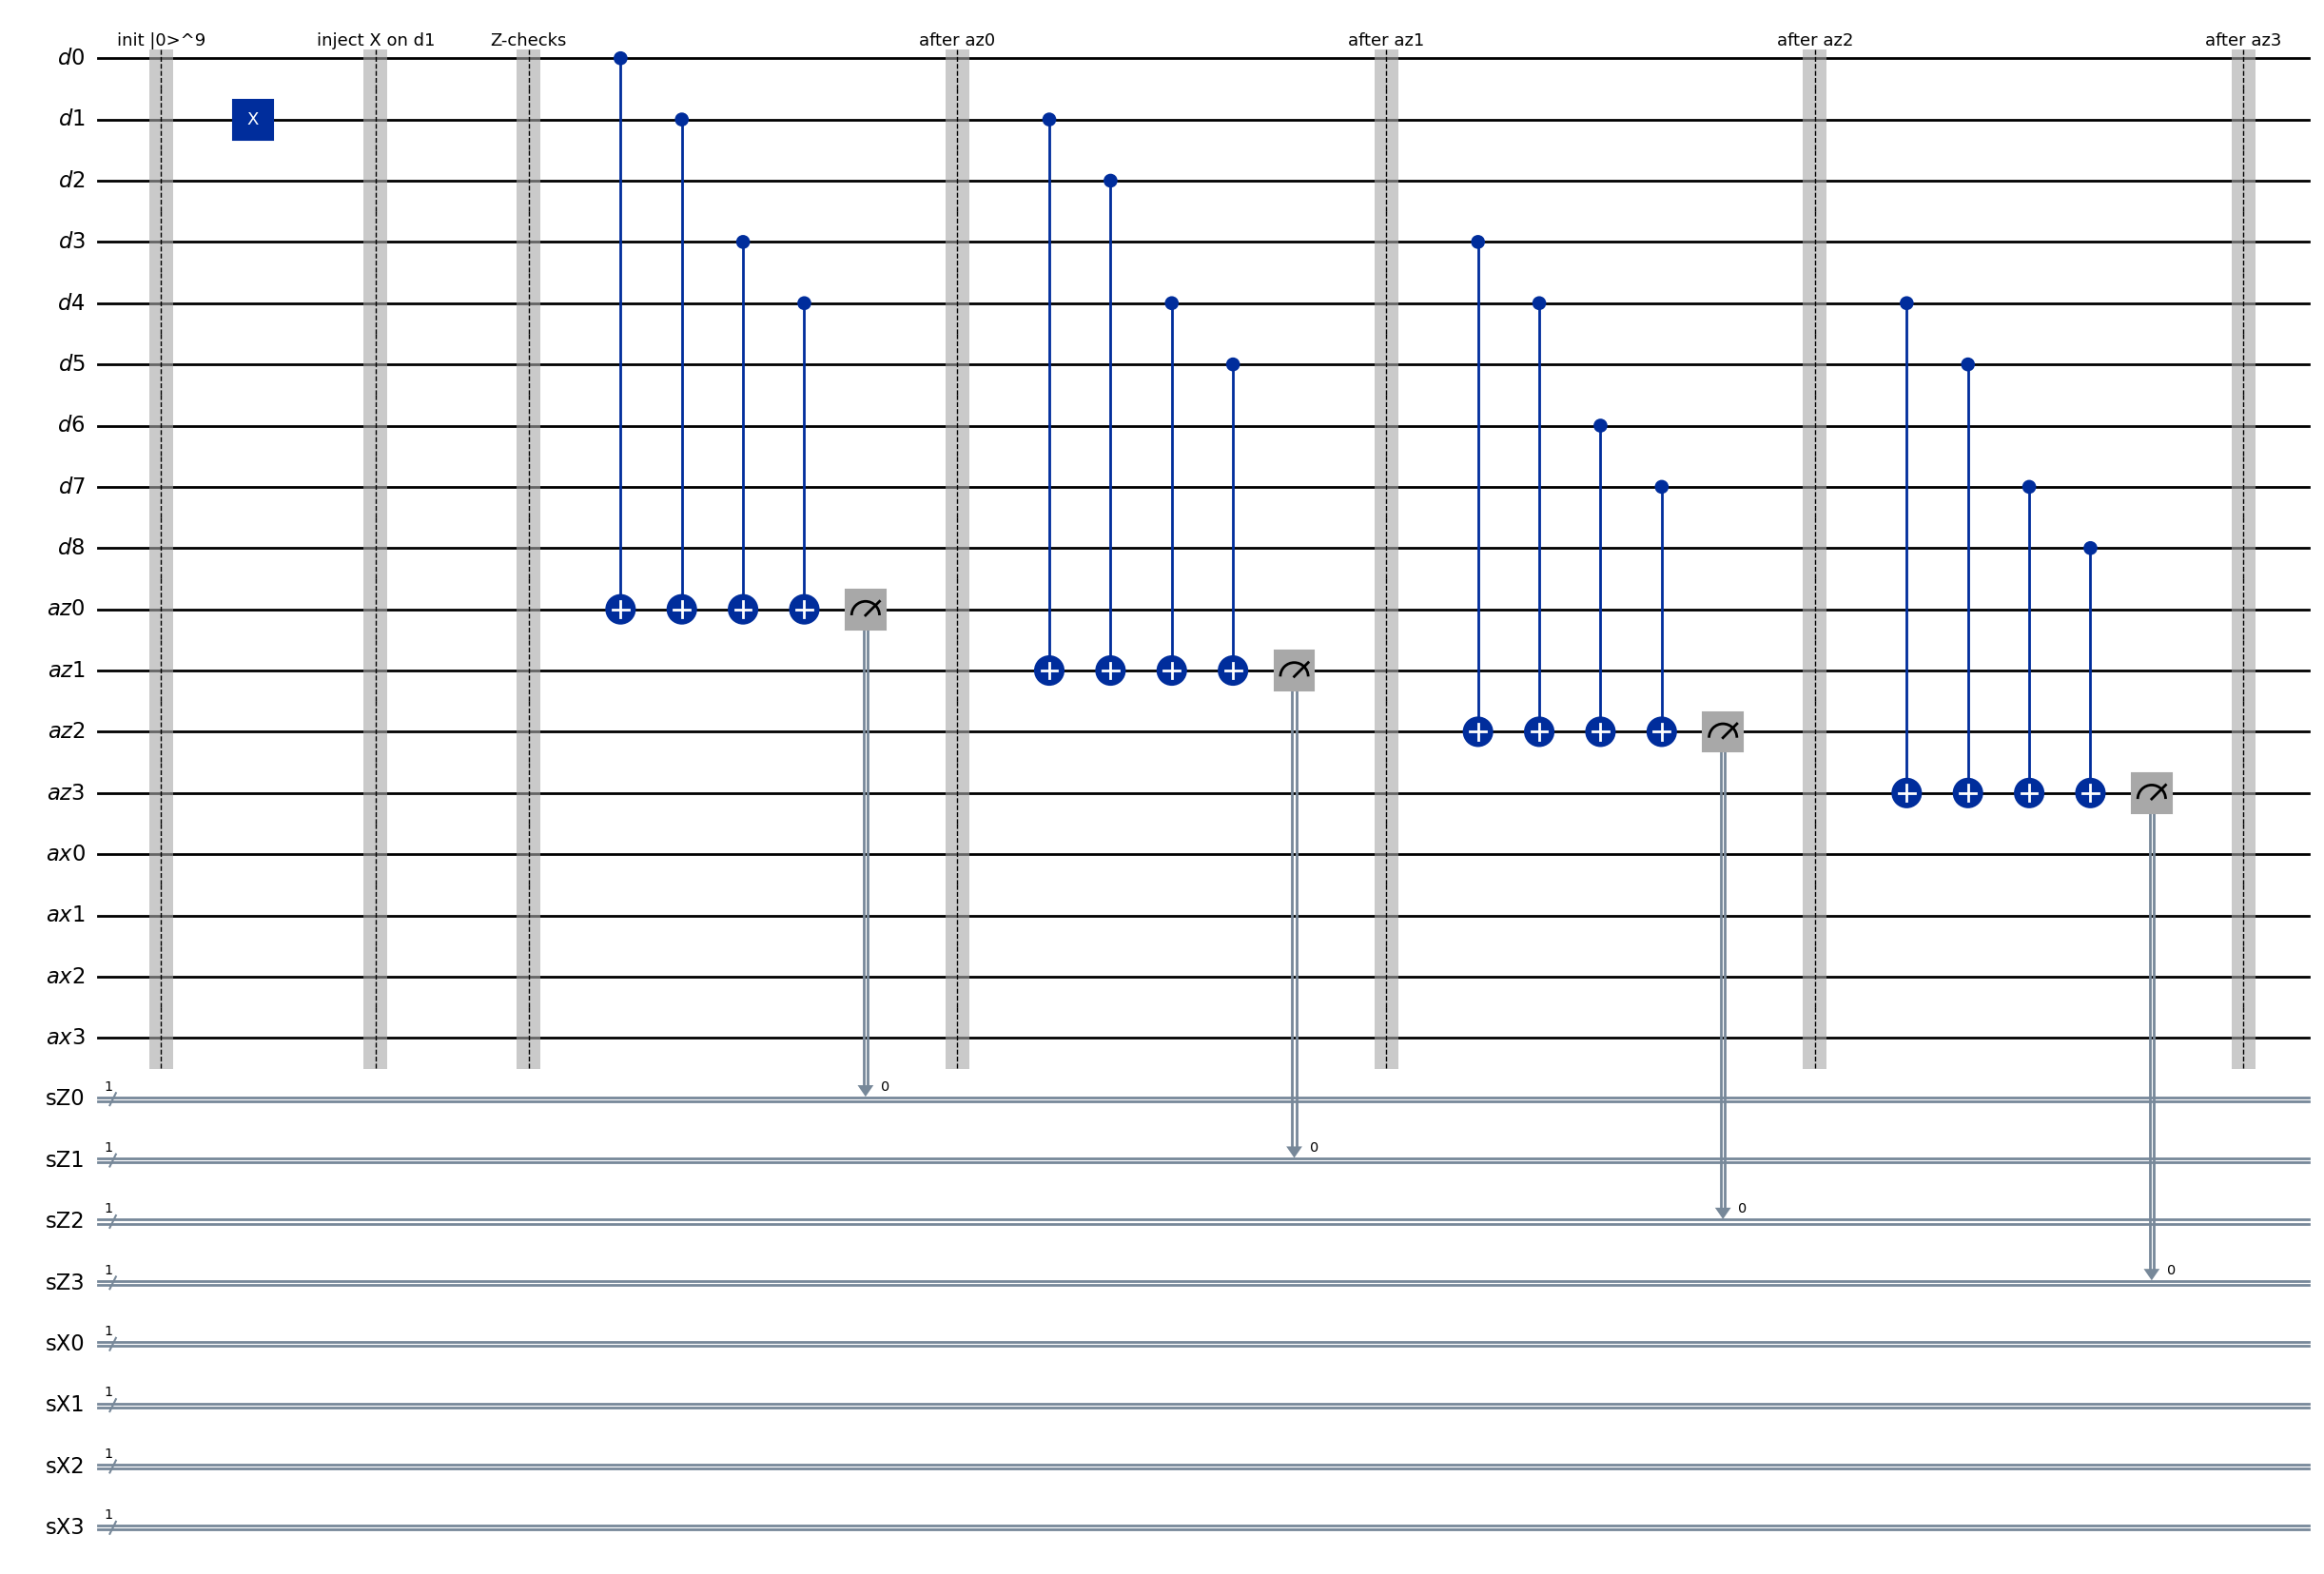

after correction counts: {'0 0 0 0 0 0 1 1': 1}
after correction sZ: [0, 0, 0, 0]  (ideally all zeros for this teaching setup)


In [12]:
def circuit_inject_X_correct_then_measure_Z(err_data="d1"):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="InjectX_correct_then_Zchecks")

    qc.barrier(label="init |0>^9")
    qc.x(Q(qregs, err_data))
    qc.barrier(label=f"inject X on {err_data}")

    # first syndrome (we do not measure mid-circuit here; we decode from theory pattern)
    # For teaching: use expected pattern from injection directly by running once on separate circuit.
    # Here we simply apply toy correction from computed sZ in a two-circuit workflow (see below).

    return qc

# --- workflow: 1) run qc_xerr to get sZ, decode; 2) build corrected circuit and re-measure ---
guess, cands = toy_decode_single_X(sZ)
print("Toy decoder candidates:", cands)
print("Toy decoder choose:", guess)

def circuit_apply_correction_then_measure_Z(correction=None):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Correct_then_Zchecks")

    qc.barrier(label="init |0>^9")
    # (for validation) we inject the same error + apply correction
    qc.x(Q(qregs, "d1"))
    qc.barrier(label="inject X on d1")

    if correction is not None:
        qc.x(Q(qregs, correction))
        qc.barrier(label=f"apply correction X on {correction}")

    qc.barrier(label="Z-checks")
    for i, stab in enumerate(Z_CHECKS):
        measure_one_z_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sZ{i}"))
        qc.barrier(label=f"after {stab['anc']}")
    return qc

qc_corr = circuit_apply_correction_then_measure_Z(guess)
display(qc_corr.draw("mpl", fold=-1))

counts2 = run_counts(qc_corr, shots=1)
key2 = list(counts2.keys())[0]
sZ2, _, sel2, _ = parse_syndrome_from_key(key2, reverse=False)

print("after correction counts:", counts2)
print("after correction sZ:", sZ2, " (ideally all zeros for this teaching setup)")


In [13]:
def build_single_Z_candidates():
    cand = {}
    for i in range(9):
        d = f"d{i}"
        pattern = tuple(1 if d in stab["data"] else 0 for stab in X_CHECKS)  # (sX0..sX3)
        cand.setdefault(pattern, []).append(d)
    return cand

Z_CAND = build_single_Z_candidates()

def toy_decode_single_Z(sX):
    pattern = tuple(sX)
    cands = Z_CAND.get(pattern, [])
    if len(cands) == 0:
        return None, []
    return sorted(cands)[0], sorted(cands)


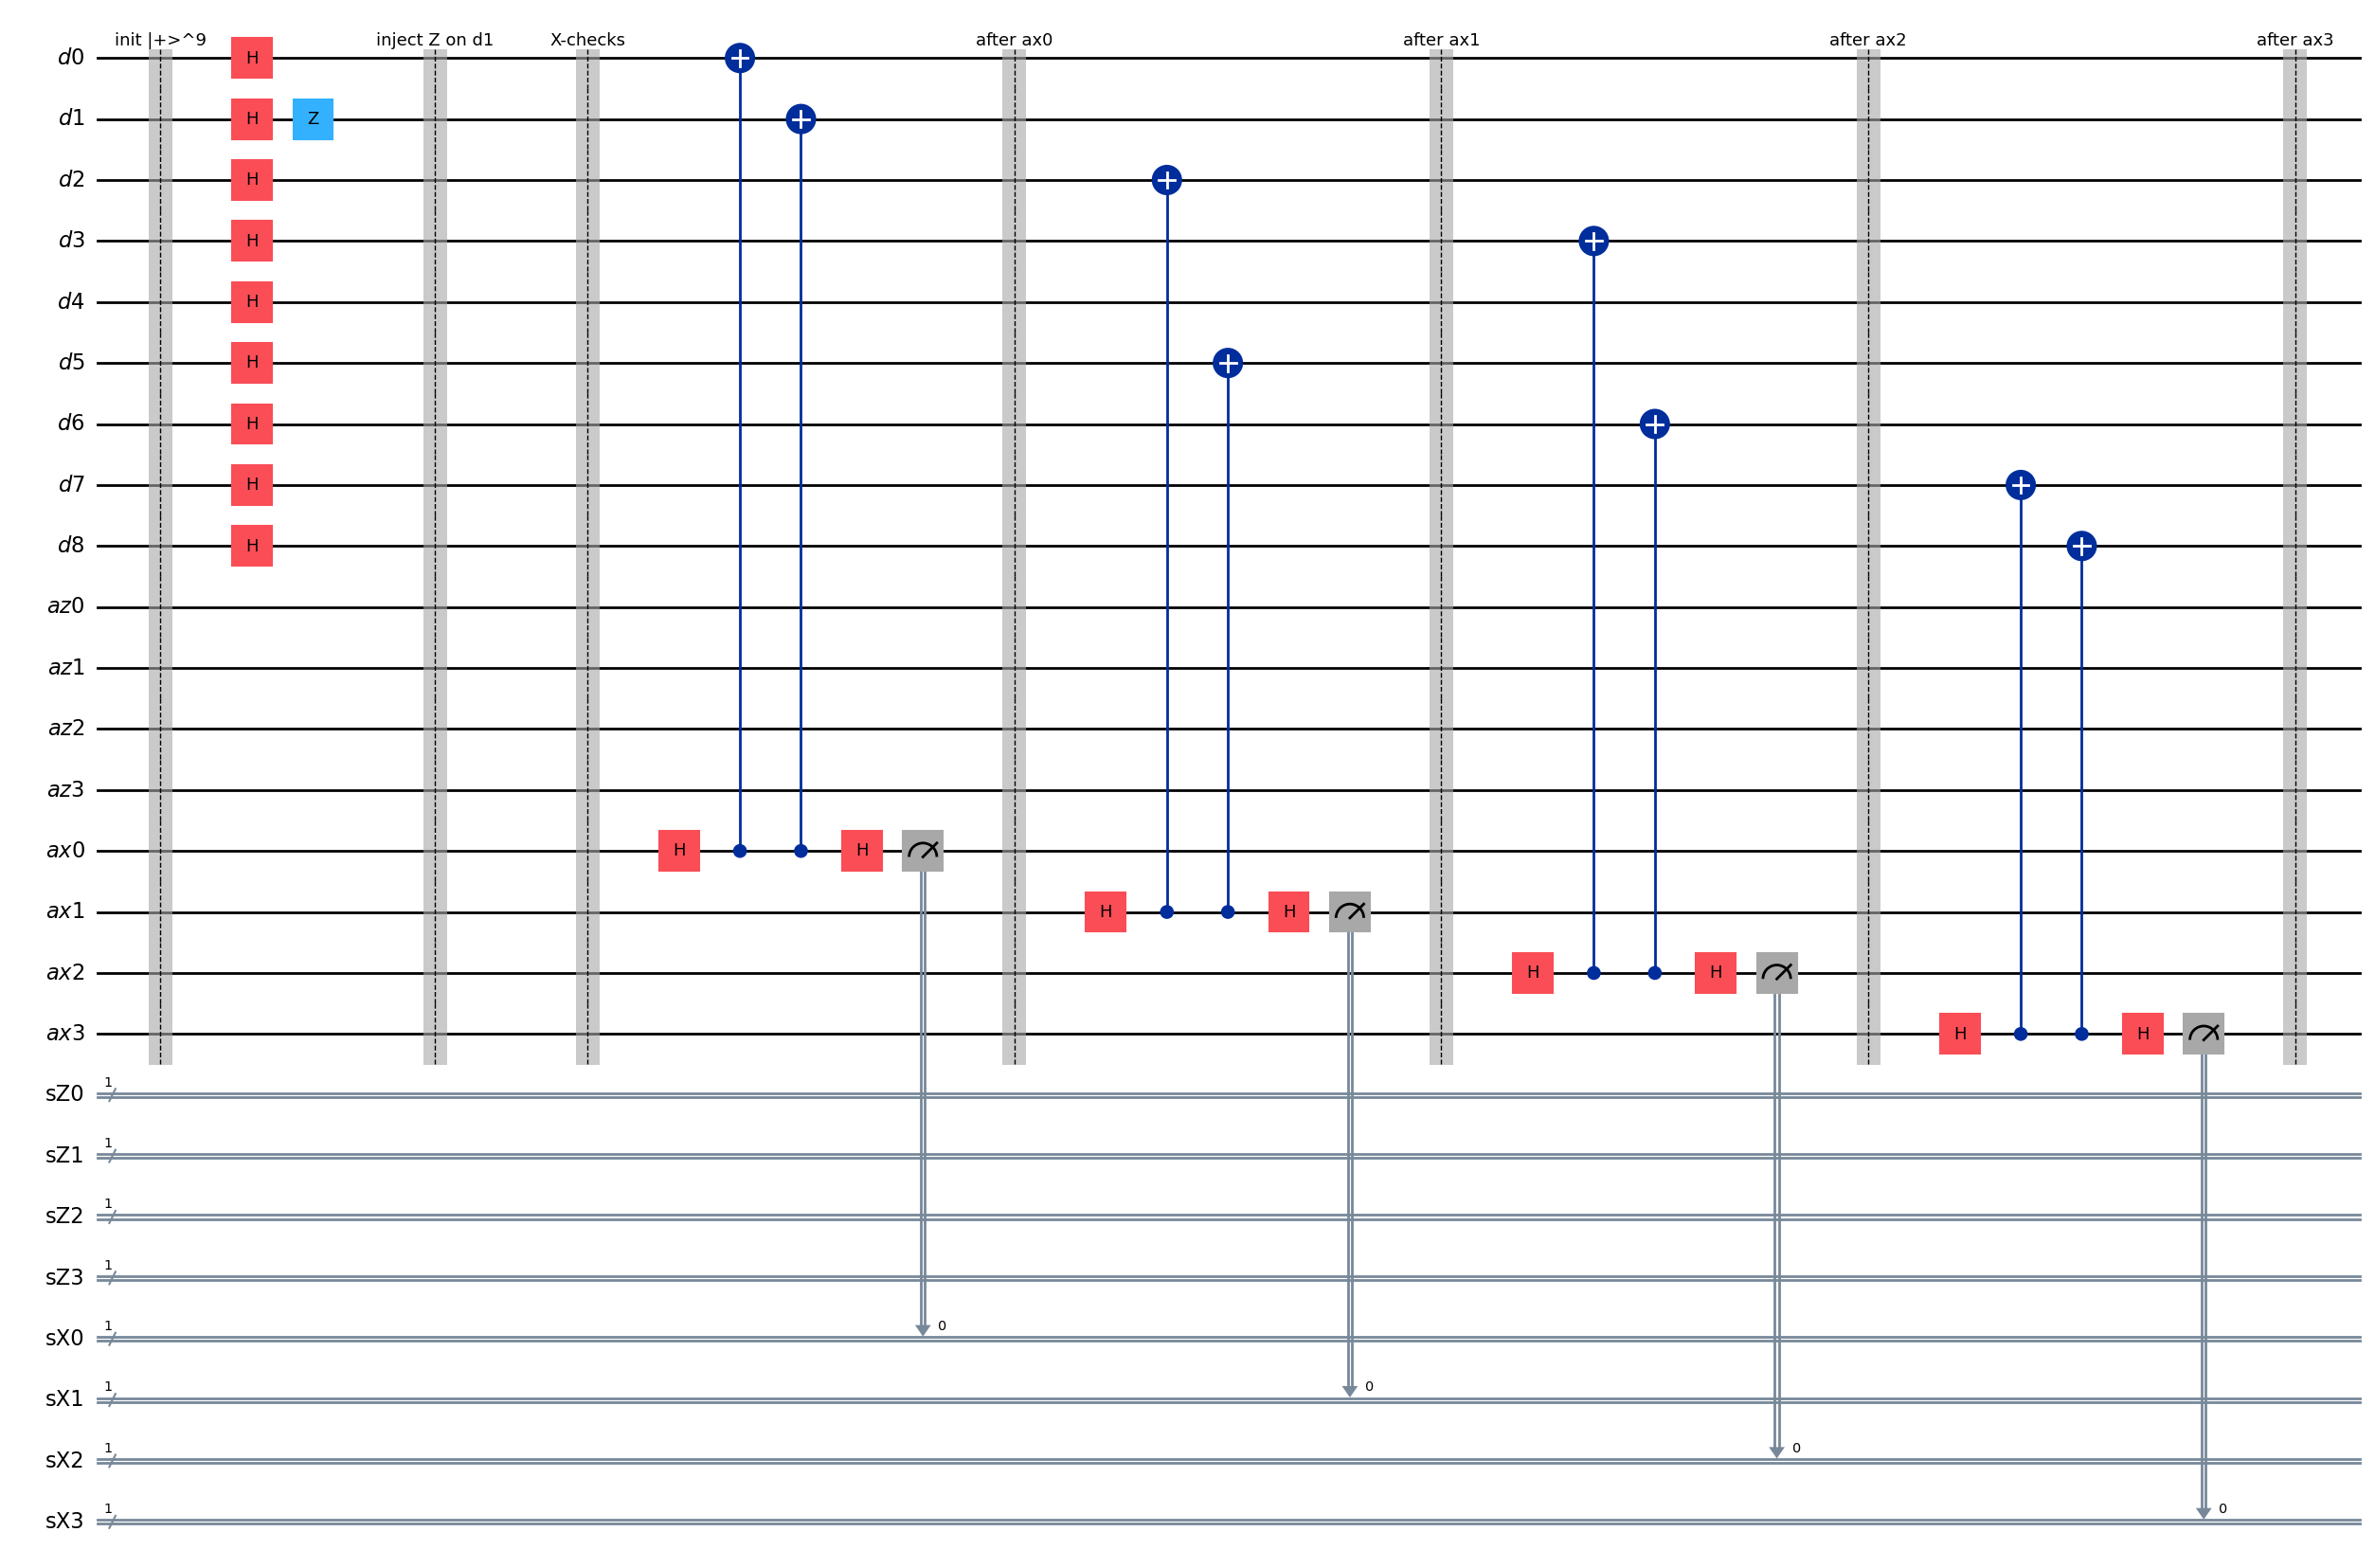

counts: {'0 0 0 1 0 0 0 0': 1}
raw key: 0 0 0 1 0 0 0 0
selected 8 bits: 00010000  (sZ0..sZ3 | sX0..sX3)
sX: [0, 0, 0, 0]    (X-check syndrome; Z errors flip these)


In [14]:
def circuit_inject_Z_then_measure_X_only(err_data="d1"):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="InjectZ_then_Xchecks")

    # data init: |+>^n  (apply H on all data)
    qc.barrier(label="init |+>^9")
    for i in range(9):
        qc.h(Q(qregs, f"d{i}"))

    # inject Z error
    qc.z(Q(qregs, err_data))
    qc.barrier(label=f"inject Z on {err_data}")

    # measure X checks only
    qc.barrier(label="X-checks")
    for i, stab in enumerate(X_CHECKS):
        measure_one_x_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sX{i}"))
        qc.barrier(label=f"after {stab['anc']}")

    return qc

qc_zerr = circuit_inject_Z_then_measure_X_only("d1")
display(qc_zerr.draw("mpl", fold=-1))

counts = run_counts(qc_zerr, shots=1)
key = list(counts.keys())[0]
sZ, sX, sel, clean = parse_syndrome_from_key(key, reverse=False)

print("counts:", counts)
print("raw key:", key)
print("selected 8 bits:", sel, " (sZ0..sZ3 | sX0..sX3)")
print("sX:", sX, "   (X-check syndrome; Z errors flip these)")


Toy decoder candidates: ['d4']
Toy decoder choose: d4


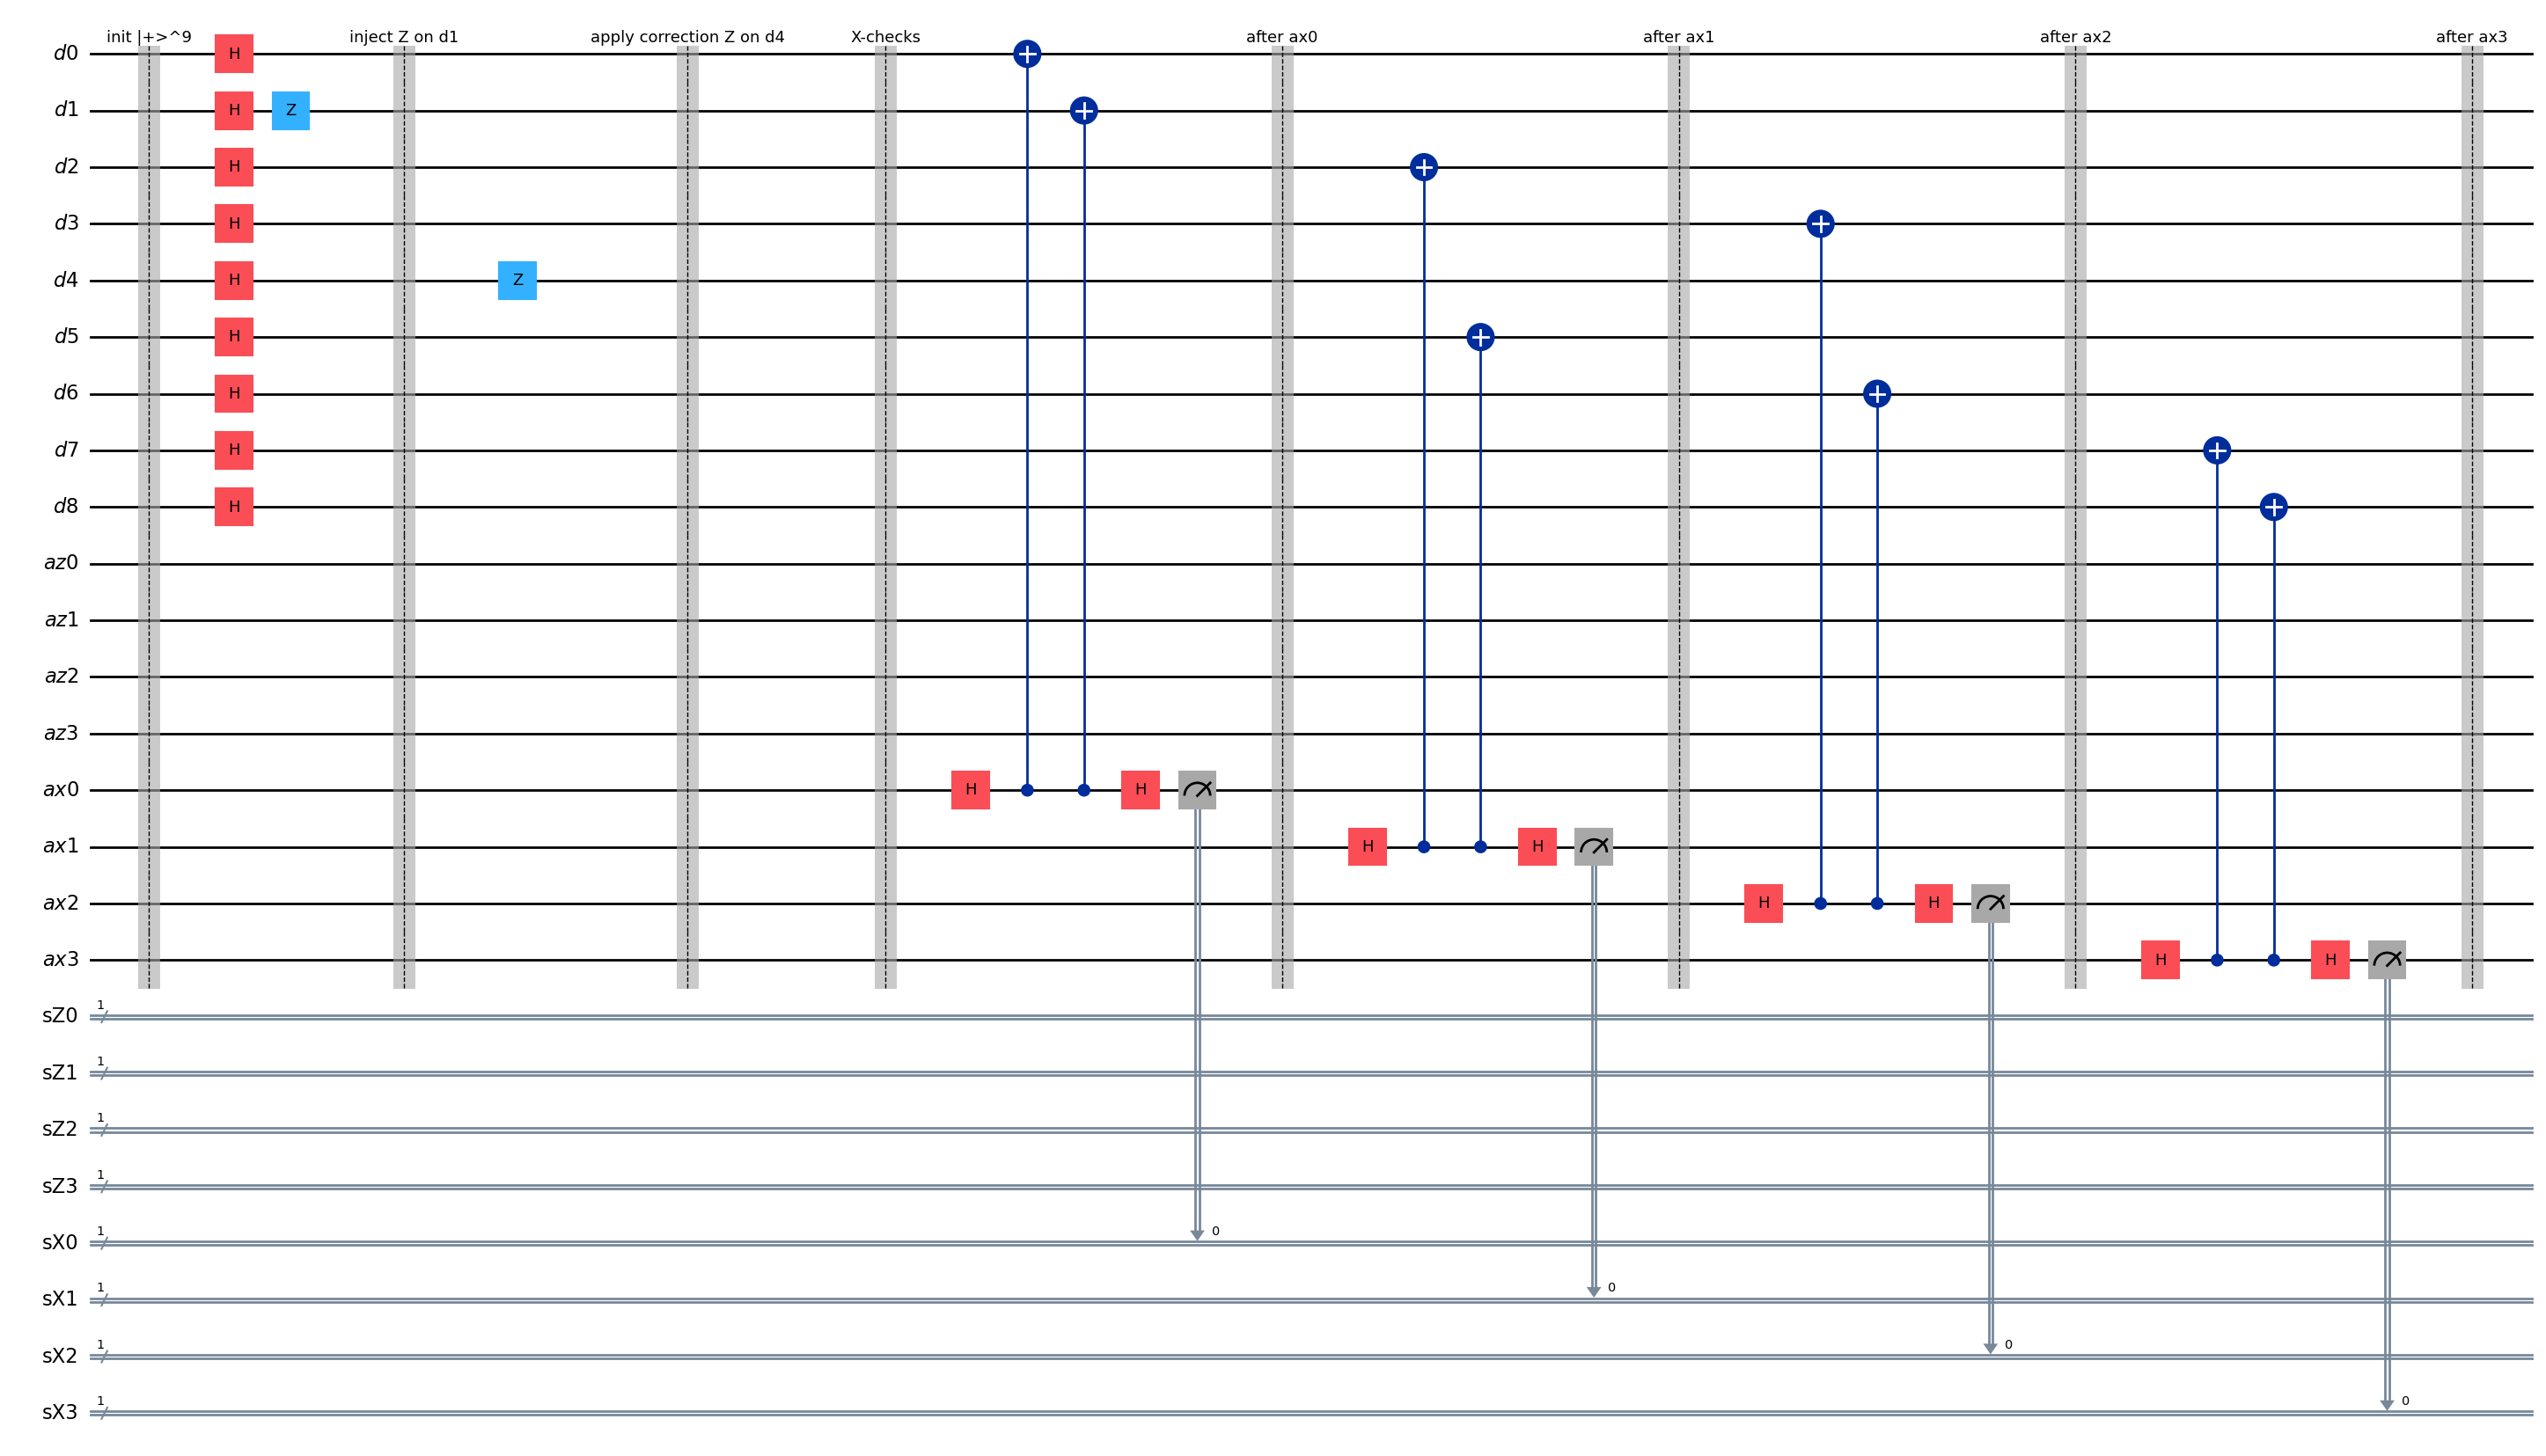

after correction counts: {'0 0 0 1 0 0 0 0': 1}
after correction sX: [0, 0, 0, 0]  (ideally all zeros for this teaching setup)


In [15]:
guessZ, candsZ = toy_decode_single_Z(sX)
print("Toy decoder candidates:", candsZ)
print("Toy decoder choose:", guessZ)

def circuit_apply_Z_correction_then_measure_X(correction=None):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="CorrectZ_then_Xchecks")

    qc.barrier(label="init |+>^9")
    for i in range(9):
        qc.h(Q(qregs, f"d{i}"))

    qc.z(Q(qregs, "d1"))
    qc.barrier(label="inject Z on d1")

    if correction is not None:
        qc.z(Q(qregs, correction))
        qc.barrier(label=f"apply correction Z on {correction}")

    qc.barrier(label="X-checks")
    for i, stab in enumerate(X_CHECKS):
        measure_one_x_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sX{i}"))
        qc.barrier(label=f"after {stab['anc']}")
    return qc

qc_corrZ = circuit_apply_Z_correction_then_measure_X(guessZ)
display(qc_corrZ.draw("mpl", fold=-1))

counts2 = run_counts(qc_corrZ, shots=1)
key2 = list(counts2.keys())[0]
_, sX2, sel2, _ = parse_syndrome_from_key(key2, reverse=False)

print("after correction counts:", counts2)
print("after correction sX:", sX2, " (ideally all zeros for this teaching setup)")
